In [2]:
# Install required packages.
from functools import partial 
import os
import torch
import time
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# %pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# %pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# %pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from ray import tune
from ray.air import session
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
# from hyperopt import hp
# from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.search.basic_variant import BasicVariantGenerator

c:\Users\jacin\OneDrive - Nanyang Technological University\Desktop\cz\cz4032\cz4032_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.1+cpu


In [3]:
def set_seed(seed: int = 42) -> None:
    # np.random.seed(seed)
    # random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [4]:
def visualize(h, filename, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    plt.savefig(filename)

def load_dataset(name):
    '''
    name: Cora, Citeseer
    '''
    dataset = Planetoid(root='data/Planetoid', name=name, transform=NormalizeFeatures())

    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

    data = dataset[0]  # Get the first graph object.

    print()
    print(data)
    print('===========================================================================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

    return dataset, data 

# Citeseer dataset 

In [5]:
dataset, data = load_dataset('Citeseer')

Dataset: Citeseer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [6]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, p1, p2, activation):
        super().__init__()
        self.p1 = p1
        self.p2 = p2
        self.activation = F.relu
        if activation == 'elu':
            self.activation = F.elu
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.p1, training=self.training)
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = F.dropout(x, p=self.p2, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [7]:
def train(gcn, optimizer, criterion):
    gcn.train()
    optimizer.zero_grad()  # Clear gradients.
    out = gcn(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def validate(gcn, criterion):
    gcn.eval()
    out = gcn(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    return val_loss.item()

def test(gcn, criterion):
    gcn.eval()
    out = gcn(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc
    

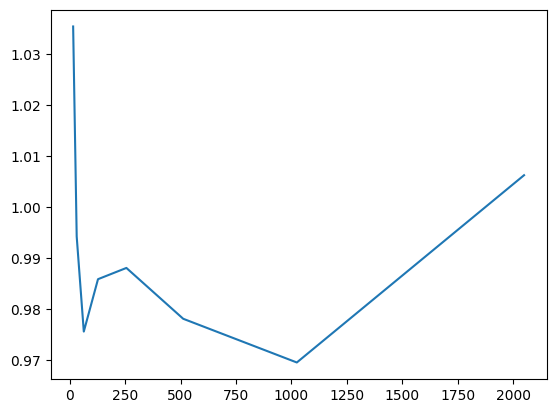

In [11]:
# Check for suitable range for hidden_channels
hiddenchannels_candidates = [16, 32, 64, 128, 256, 512, 1024, 2048]
val_loss = []
for i in hiddenchannels_candidates:
    gcn = GCN(hidden_channels=i, p1=0.6, p2=0.6, activation='elu')
    optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    torch.save(gcn, 'best_model_hidden_channels.pt')
    for epoch in range(200):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            torch.save(gcn, 'best_model_hidden_channels.pt')
    gcn = torch.load('best_model_hidden_channels.pt')
    gcn.eval()
    val_loss.append(validate(gcn, criterion))

plt.plot(hiddenchannels_candidates, val_loss)
plt.show()

We want to minimise the validation loss. Hence, it seems like number of hidden channels 256, 512, 1024 are good candidates for our parameter space

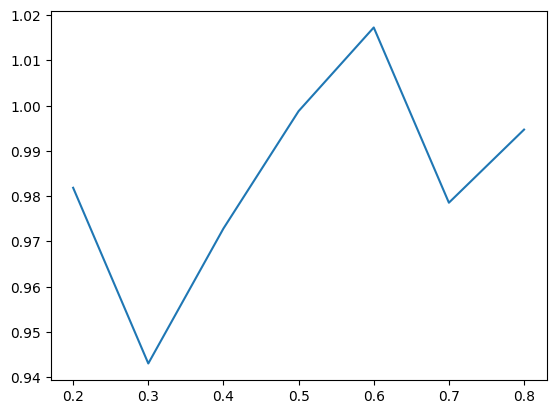

In [13]:
# Check for suitable range for p1
p1_candidates = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
val_loss = []
for i in p1_candidates:
    gcn = GCN(hidden_channels=512, p1=i, p2=0.6, activation='elu')
    optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    torch.save(gcn, 'best_model_p1.pt')
    for epoch in range(200):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            torch.save(gcn, 'best_model_p1.pt')
    gcn = torch.load('best_model_p1.pt')
    gcn.eval()
    val_loss.append(validate(gcn, criterion))

plt.plot(p1_candidates, val_loss)
plt.show()

p1 should be between 0.2 to 0.4

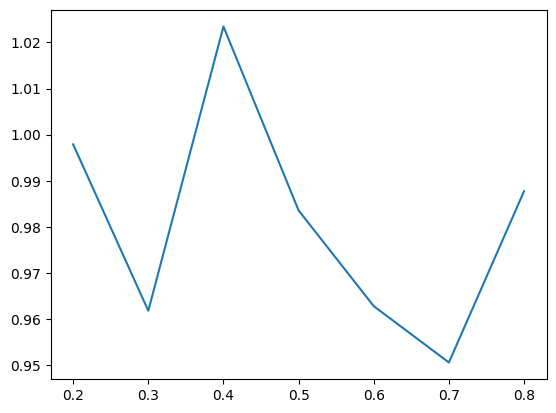

In [14]:
# Check for suitable range for p2
p2_candidates = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
val_loss = []
for i in p2_candidates:
    gcn = GCN(hidden_channels=512, p1=0.6, p2=i, activation='elu')
    optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    torch.save(gcn, 'best_model_p2.pt')
    for epoch in range(200):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            torch.save(gcn, 'best_model_p2.pt')
    gcn = torch.load('best_model_p2.pt')
    gcn.eval()
    val_loss.append(validate(gcn, criterion))

plt.plot(p2_candidates, val_loss)
plt.show()

p2 should be between 0.5 to 0.7

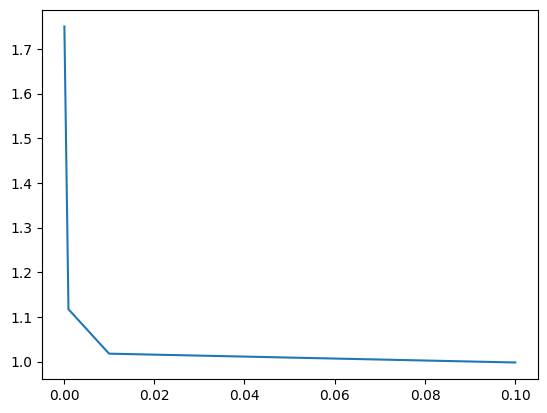

In [15]:
# Check for suitable range for learning rate
lr_candidates = [0.0001, 0.001, 0.01, 0.1]
val_loss = []
for i in lr_candidates:
    gcn = GCN(hidden_channels=512, p1=0.6, p2=0.6, activation='elu')
    optimizer = torch.optim.Adam(gcn.parameters(), lr=i, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    torch.save(gcn, 'best_model_lr.pt')
    for epoch in range(200):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            torch.save(gcn, 'best_model_lr.pt')
    gcn = torch.load('best_model_lr.pt')
    gcn.eval()
    val_loss.append(validate(gcn, criterion))

plt.plot(lr_candidates, val_loss)
plt.show()

lr from range of 0.01 to 0.1 seems good

## Model Tuning

In [8]:
def train_gcn(config):
    gcn = GCN(config['hidden_channels'], config['p1'], config['p2'], config['activation'])
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(gcn.parameters(), lr=config['lr'], weight_decay=5e-4)
    gcn.train()
    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    for epoch in range(200):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            best_loss = validate_loss
    session.report({'best_loss': validate_loss})
config = {
    'hidden_channels': tune.choice([256, 512, 1024]),
    'lr': tune.loguniform(1e-2, 1e-1),
    'p1': tune.quniform(0.2, 0.4, 0.1),
    'p2': tune.quniform(0.5, 0.7, 0.1),
    'activation': tune.choice(['relu', 'elu'])
}
tuner = tune.Tuner(
    train_gcn,
    tune_config=tune.TuneConfig(
        num_samples=100,
        mode='min',
        metric='best_loss'
    ),
    param_space=config
)

In [9]:
results = tuner.fit()

2022-10-15 01:28:51,315	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-15 01:28:54,651	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,activation,hidden_channels,lr,p1,p2,iter,total time (s),best_loss
train_gcn_adfe9_00000,TERMINATED,127.0.0.1:15024,relu,512,0.0818622,0.4,0.6,1,252.212,0.992088
train_gcn_adfe9_00001,TERMINATED,127.0.0.1:21344,elu,1024,0.0116999,0.3,0.5,1,591.168,0.95427
train_gcn_adfe9_00002,TERMINATED,127.0.0.1:9124,elu,1024,0.0184535,0.3,0.6,1,609.941,0.999604
train_gcn_adfe9_00003,TERMINATED,127.0.0.1:21952,elu,1024,0.0358227,0.3,0.7,1,617.658,1.01221
train_gcn_adfe9_00004,TERMINATED,127.0.0.1:22496,elu,512,0.0144174,0.4,0.6,1,324.135,0.94333
train_gcn_adfe9_00005,TERMINATED,127.0.0.1:16680,elu,1024,0.0114636,0.3,0.5,1,614.859,0.936543
train_gcn_adfe9_00006,TERMINATED,127.0.0.1:14620,relu,1024,0.0488416,0.2,0.6,1,550.563,0.940697
train_gcn_adfe9_00007,TERMINATED,127.0.0.1:11208,elu,256,0.0224027,0.2,0.5,1,185.981,0.944911
train_gcn_adfe9_00008,TERMINATED,127.0.0.1:15024,elu,1024,0.0108954,0.2,0.5,1,625.761,0.953736
train_gcn_adfe9_00009,TERMINATED,127.0.0.1:11208,elu,256,0.0197877,0.3,0.5,1,180.091,0.985823


2022-10-15 01:29:35,254	WARNING worker.py:1829 -- Warning: The actor ImplicitFunc is very large (94 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-10-15 01:29:35,635	WARNING util.py:220 -- The `start_trial` operation took 2.853 s, which may be a performance bottleneck.
2022-10-15 01:29:46,795	WARNING util.py:220 -- The `start_trial` operation took 1.676 s, which may be a performance bottleneck.
2022-10-15 01:29:59,723	WARNING util.py:220 -- The `start_trial` operation took 1.910 s, which may be a performance bottleneck.
2022-10-15 01:30:12,142	WARNING util.py:220 -- The `start_trial` operation took 2.351 s, which may be a performance bottleneck.
2022-10-15 01:30:25,288	WARNING util.py:220 -- The `start_trial` operation took 2.638 s, which may be a performance bottleneck.
2022-10-15 01:30:42,086	WARNING util.py:220 -- The `start_trial` operation took 3.184 s, which 

Result for train_gcn_adfe9_00000:
  best_loss: 0.9920883774757385
  date: 2022-10-15_01-33-54
  done: false
  experiment_id: 4f06fa7a627f4b9185cf64acb3ca02f4
  hostname: Jacintha
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 15024
  time_since_restore: 252.21153211593628
  time_this_iter_s: 252.21153211593628
  time_total_s: 252.21153211593628
  timestamp: 1665768834
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: adfe9_00000
  warmup_time: 0.010776758193969727
  
Result for train_gcn_adfe9_00000:
  best_loss: 0.9920883774757385
  date: 2022-10-15_01-33-54
  done: true
  experiment_id: 4f06fa7a627f4b9185cf64acb3ca02f4
  experiment_tag: 0_activation=relu,hidden_channels=512,lr=0.0819,p1=0.4000,p2=0.6000
  hostname: Jacintha
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 15024
  time_since_restore: 252.21153211593628
  time_this_iter_s: 252.21153211593628
  time_total_s: 252.21153211593628
  timestamp: 1665768834
  timesteps_since_restore: 0
  trai

2022-10-15 02:47:46,808	INFO tune.py:758 -- Total run time: 4732.16 seconds (4730.90 seconds for the tuning loop).


In [10]:
best_config = results.get_best_result(metric='best_loss', mode='min').config
best_config

{'hidden_channels': 1024,
 'lr': 0.058086323278576144,
 'p1': 0.2,
 'p2': 0.5,
 'activation': 'relu'}

In [11]:
test_acc = []
train_time = []
seeds = [1, 12, 123, 1234, 12345, 123456, 1234567, 12345678, 123456789, 1234567890]
all_results = []
for seed in seeds:
    set_seed(seed)
    start = time.process_time()
    gcn = GCN(best_config['hidden_channels'], best_config['p1'], best_config['p2'], best_config['activation'])
    optimizer = torch.optim.Adam(gcn.parameters(), lr=best_config['lr'], weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    train_loss = train(gcn, optimizer, criterion)
    best_loss = validate(gcn, criterion)
    torch.save(gcn, 'best-model.pt')
    for epoch in range(200):
        train_loss = train(gcn, optimizer, criterion)
        validate_loss = validate(gcn, criterion)
        if abs(validate_loss) < abs(best_loss):
            torch.save(gcn, 'best-model.pt')
    train_time.append(time.process_time() - start)
    gcn = torch.load('best-model.pt')
    gcn.eval()
    print(test(gcn, criterion))
    test_acc.append(test(gcn, criterion))
    res = {}
    res['seed'] = seed
    res['hidden_channles'] = best_config['hidden_channels']
    res['p1'] = best_config['p1']
    res['p2'] = best_config['p2']
    res['lr'] = best_config['lr']
    res['activation'] = best_config['activation']
    res['test_acc'] = test(gcn, criterion)
    res['time'] = (time.process_time() - start)
    all_results.append(res)

Random seed set as 1
0.678
Random seed set as 12
0.707
Random seed set as 123
0.699
Random seed set as 1234
0.711
Random seed set as 12345
0.705
Random seed set as 123456
0.686
Random seed set as 1234567
0.698
Random seed set as 12345678
0.68
Random seed set as 123456789
0.641
Random seed set as 1234567890
0.69


In [12]:
print("train time: ", train_time)
print("average train time: ",sum(train_time)/len(train_time))

train time:  [321.984375, 452.875, 728.296875, 649.75, 774.796875, 632.03125, 779.734375, 763.828125, 722.625, 752.5625]
average train time:  657.8484375


In [13]:
print("average acuracy: ", sum(test_acc)/len(test_acc))

average acuracy:  0.6895


In [14]:
import csv

keys = all_results[0].keys()

with open('gcn_citeseer_results.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(all_results)

Exception in thread 2022-10-15 16:59:25,335	ERROR import_thread.py:76 -- ImportThread: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Stream removed"
	debug_error_string = "{"created":"@1665824365.332000000","description":"Error received from peer ipv4:127.0.0.1:56748","file":"src/core/lib/surface/call.cc","file_line":1075,"grpc_message":"Stream removed","grpc_status":2}"
>
ray_listen_error_messages2022-10-15 16:59:25,347	ERROR worker.py:806 -- print_logs: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNKNOWN
	details = "Stream removed"
	debug_error_string = "{"created":"@1665824365.332000000","description":"Error received from peer ipv4:127.0.0.1:56748","file":"src/core/lib/surface/call.cc","file_line":1075,"grpc_message":"Stream removed","grpc_status":2}"
>
:
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\threadi